En este archivo puedes escribir lo que estimes conveniente. Te recomendamos detallar tu solución y todas las suposiciones que estás considerando. Aquí puedes ejecutar las funciones que definiste en los otros archivos de la carpeta src, medir el tiempo, memoria, etc.

In [9]:
file_path = "../resources/farmers-protest-tweets-2021-2-4.json"
import matplotlib.pyplot as plt
import memory_profiler

def plot(x_values, y_values, x_label, y_label, title=''):
    plt.plot(x_values, y_values, marker='o')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

For the first exercise q1_memory,  I've implemented two approaches. Lets run them in two different cells and decide what is the best
1. For the first one
- Get a list with all tuples (date, username)
- Get top 10 of posted dates
- Get top 1 user who posted in each day

In [24]:
from q1_memory import q1_memory
%load_ext memory_profiler
%mprun -f q1_memory q1_memory(file_path)

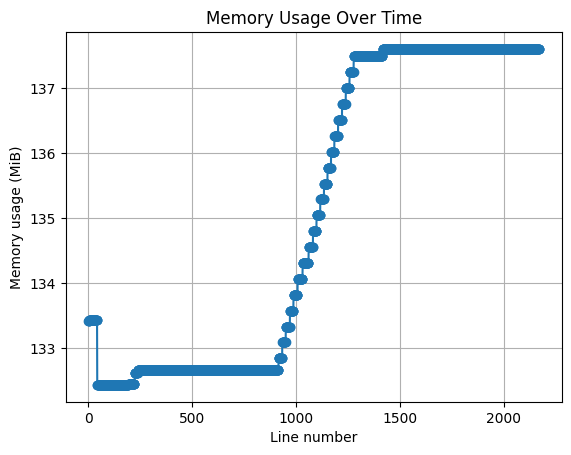

In [19]:
from q1_memory import q1_memory
memory_usage = memory_profiler.memory_usage((q1_memory, (), {'file_path': file_path}))
x_values = list(range(1, len(memory_usage) + 1))  
# Plot the memory usage over time
plot(x_values, memory_usage, 'Line number' ,'Memory usage (MiB)', 'Memory Usage Over Time')

2. Second Approach:
- Retrieve the top 10 dates.
- Filter users who posted on those days.
- For each day, identify the top user who posted on that day.
Based on the results, this approach proves superior as it exclusively fetches the required dates while disregarding the remainder. 

In [36]:
from q1_memory import q1_memory_v2
%load_ext memory_profiler
%mprun -f q1_memory_v2 q1_memory_v2(file_path)

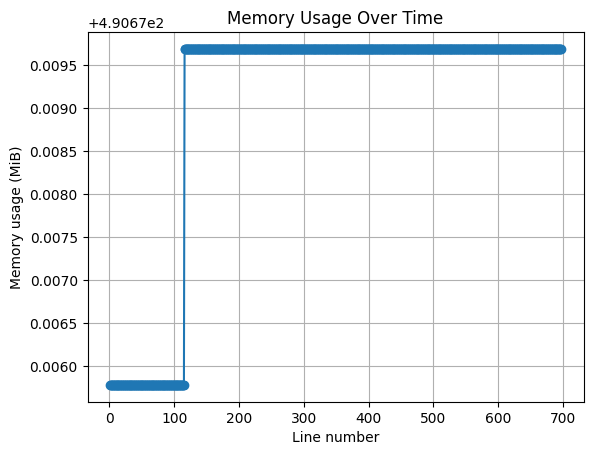

In [32]:
from q1_memory import q1_memory_v2
memory_usage = memory_profiler.memory_usage((q1_memory_v2, (), {'file_path': file_path}))
x_values = list(range(1, len(memory_usage) + 1))  
# Plot the memory usage over time
plot(x_values, memory_usage, 'Line number' ,'Memory usage (MiB)', 'Memory Usage Over Time')

Exercise 1 q1_time: This time, I've opted to utilize Pandas due to its utilization of NumPy under the hood. The NumPy library, partially written in C, significantly enhances performance compared to native Python, often by orders of magnitude.
The following cell employs cProfile and pstats to execute q1_time and measure its execution time. I've chosen to display only the 15 functions with the longest execution times.

In [23]:
from cProfile import Profile
from pstats import Stats, SortKey
from q1_time import q1_time

with Profile() as profile:
    q1_time(file_path)
    (
     Stats(profile)
     .strip_dirs()
     .sort_stats(SortKey.TIME)
     .print_stats(15)
    )

         499756 function calls (499545 primitive calls) in 6.577 seconds

   Ordered by: internal time
   List reduced from 816 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    4.101    4.101    4.145    4.145 decoder.py:343(raw_decode)
        1    0.737    0.737    0.850    0.850 {method 'readlines' of '_io._IOBase' objects}
        1    0.250    0.250    6.118    6.118 q1_time.py:8(read_dataframe)
        1    0.213    0.213    0.213    0.213 {method 'join' of 'str' objects}
       21    0.162    0.008    0.165    0.008 construction.py:1028(convert)
        1    0.134    0.134    0.222    0.222 construction.py:891(_list_of_dict_to_arrays)
        1    0.130    0.130    0.130    0.130 datetimes.py:456(_array_strptime_with_fallback)
        5    0.101    0.020    0.109    0.022 managers.py:2244(_stack_arrays)
    49772    0.079    0.000    0.079    0.000 {built-in method _codecs.utf_8_decode}
        4    0.067    0.01

Exercise 2: 
Memory problem: To solve this exercise I've decided to use to external libraries emoji and regex. The last allows to find grapheme clusters occurrences

In [10]:
from q2_memory import q2_memory
%reload_ext memory_profiler
%mprun -f q2_memory q2_memory(file_path)

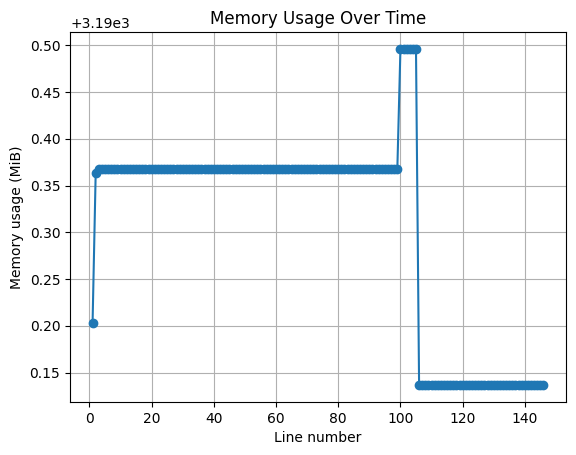

In [11]:
from q2_memory import q2_memory
memory_usage = memory_profiler.memory_usage((q2_memory, (), {'file_path': file_path}))
x_values = list(range(1, len(memory_usage) + 1))  
# Plot the memory usage over time
plot(x_values, memory_usage, 'Line number' ,'Memory usage (MiB)', 'Memory Usage Over Time')